<a href="https://colab.research.google.com/github/Tanjul5/Speech-Emotion-Recognition/blob/main/speech_emotion_recognition_capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Speech Emotion Recognition(SER)**

###**Emotion classification using the RAVDESS dataset**

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is licensed under CC BY-NA-SC 4.0. and can be downloaded free of charge at https://zenodo.org/record/1188976.

**Construction and Validation**

Construction and validation of the RAVDESS is described in our paper: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. Validation data is open-access, and can be downloaded along with our paper from PLOS ONE.

**Description**

The dataset contains the complete set of 7356 RAVDESS files (total size: 24.8 GB). Each of the 24 actors consists of three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound). Note, there are no song files for Actor_18.

**Data**

For this task, we are using 1440 samples from the RAVDESS dataset.

The samples comes from:


**Audio-files(speech only)**

**License information**

The RAVDESS is released under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License, CC BY-NA-SC 4.0

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

**Filename identifiers**

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
*   Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


Filename example: 02-01-06-01-02-01-12.mp4

*   Video-only (02)
*   Speech (01)
*   Fearful (06)
*   Normal intensity (01)
*   Statement “dogs” (02)
*   1st Repetition (01)
*   12th Actor (12)
*   Female, as the actor ID number is even.


## **Analysis**
We are using Google Colab, a Google Cloud environment for jupyter, so we need to import our files from Google Drive and then install LibROSA, a python package for music and audio analysis.

After the import, we will plot the signal of the first file.



###**Importing Libraries**

In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
from tqdm import tqdm

import os, glob, sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline

import soundfile as sf
import IPython.display as ipd
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPool2D, Conv1D, MaxPool1D

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#mounting the google drive to import the dataset

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
audio = "/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/RAVDESS/"

# DATA PREPROCESSING

In [4]:
# CREATE DIRECTORY OF AUDIO FILES 
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

**We have converted audio speech files into List dtype.**

In [5]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [6]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
1,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
2,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
3,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
4,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...


# **Data visulization**

# **COUNTS OF EMOTION**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


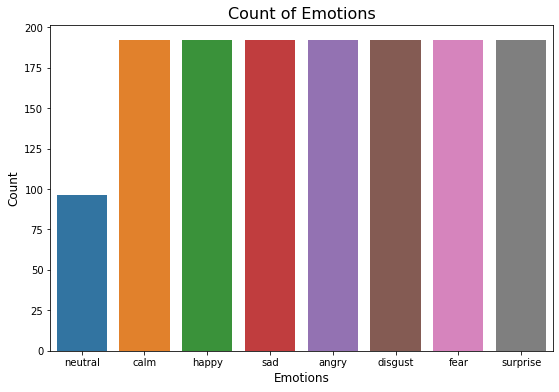

In [7]:
plt.figure(figsize=(9,6))
plt.title('Count of Emotions', size=16)
sns.countplot(audio_df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

***There are eight type of emotions are present in dataset as neutral, calm, happy, sad, angry, fear, disgust, surprise. Neutral emotion data is less in numbers as compared to other emotions.***

We can also plot waveplots and spectograms for audio signals

Waveplots - Waveplots let us know the loudness of the audio at a given time.

Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

### **Male Happy**

Text(0.5, 1.0, 'Waveplot - Male Happy')

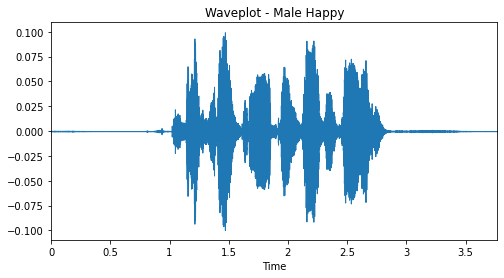

In [8]:
# DISPLAY WAVEPLOT
x, sr = librosa.load(f'/{audio}/Actor_03/03-01-03-01-01-01-03.wav')

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Happy')

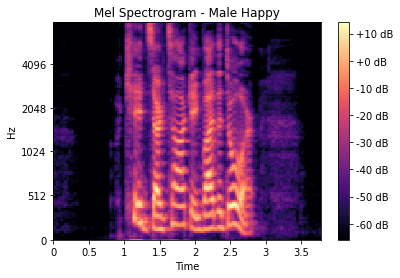

In [9]:
# CREATE LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
x = librosa.power_to_db(x)

librosa.display.specshow(x, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.colorbar(format='%+2.0f dB');

### **Male Angry**

Text(0.5, 1.0, 'Waveplot - Male Angry')

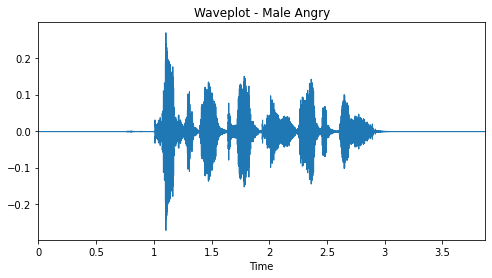

In [10]:
# LOAD FILE
x, sr = librosa.load(f'/{audio}/Actor_05/03-01-05-01-01-01-05.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Angry')

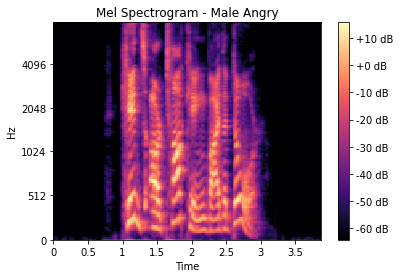

In [11]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Angry');
plt.colorbar(format='%+2.0f dB');

#### **Female Fearful**

Text(0.5, 1.0, 'Waveplot - Female Fearful')

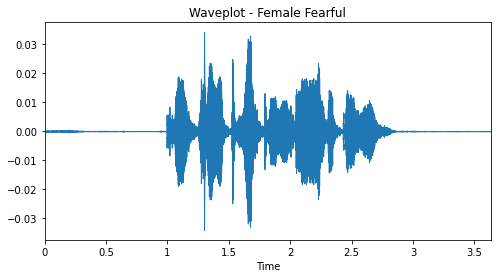

In [12]:
# LOAD FILE
x, sr = librosa.load(f'/{audio}/Actor_06/03-01-06-01-01-01-06.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Female Fearful')

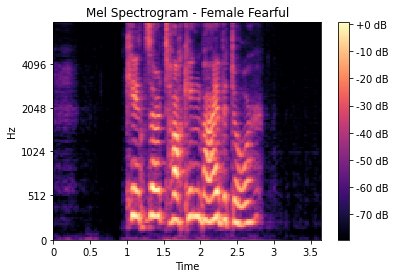

In [13]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fearful')
plt.colorbar(format='%+2.0f dB');

#### **Female Surprised**

Text(0.5, 1.0, 'Waveplot - FemaleSurprised')

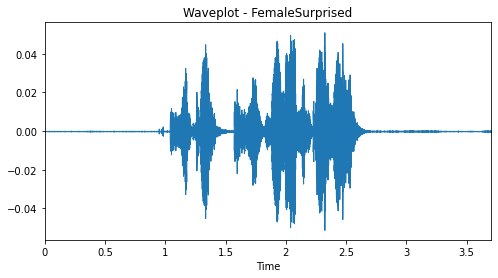

In [14]:
# LOAD FILE
x, sr = librosa.load(f'/{audio}/Actor_08/03-01-08-01-01-01-08.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - FemaleSurprised')

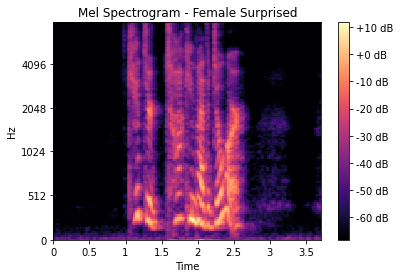

In [15]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Surprised')
plt.colorbar(format='%+2.0f dB');

**So in above plots we have created a Waveplots and Mel Spectrograms for different emotions classifications.**

**So we have extracted the audio speech files path and created a DataFrame out of it.**

In [16]:
#shape of the dataframe
audio_df.shape

(1440, 4)

In [17]:
# EXPORT TO CSV
audio_df.to_csv('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/RAVDAS.csv')

In [18]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/RAVDAS.csv',usecols=['emotion','path','gender','actor'])
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
1,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
2,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
3,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
4,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...


In [19]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [20]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 1)


# Data Augmentation

Add Noise, Stretch, Speed and Pitch to Original Audio File

Text(0.5, 1.0, 'Waveplot - Male happy')

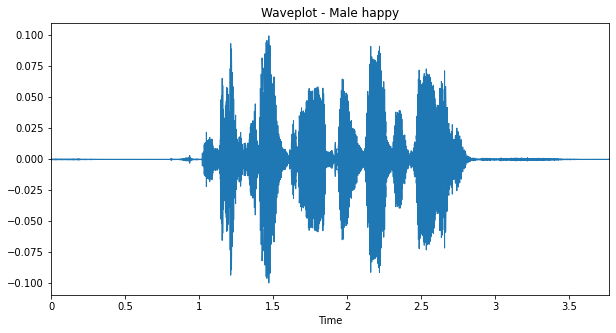

In [21]:
# MALE Happy ORIGINAL AUDIO FILE
fname = audio + 'Actor_03/03-01-03-01-01-01-03.wav'  
X, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(X, sr=sr)
plt.title('Waveplot - Male happy')

# **NOISE**

In [22]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

Text(0.5, 1.0, 'Waveplot - Noise Male Happy')

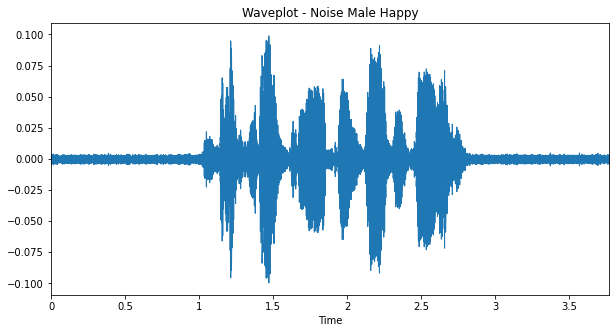

In [23]:
 #ADD NOISE TO MALE Happy ORIGINAL AUDIO FILE
x = noise(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Noise Male Happy')

**STRECH**

In [24]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

Text(0.5, 1.0, 'Waveplot - Stretch Male Happy')

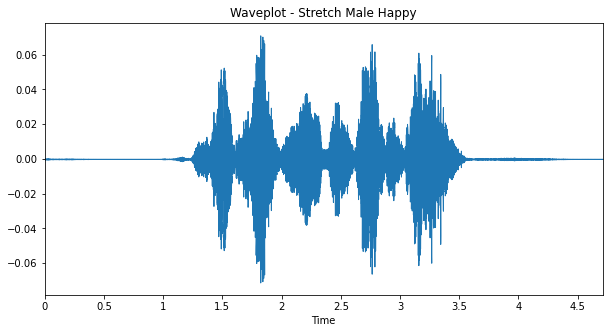

In [25]:
# ADD STRETCH TO MALE Happy ORIGINAL AUDIO FILE
x = stretch(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch Male Happy')

# **Speed N Pitch**

In [26]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

Text(0.5, 1.0, 'Waveplot - Speed and Pitch Male Happy')

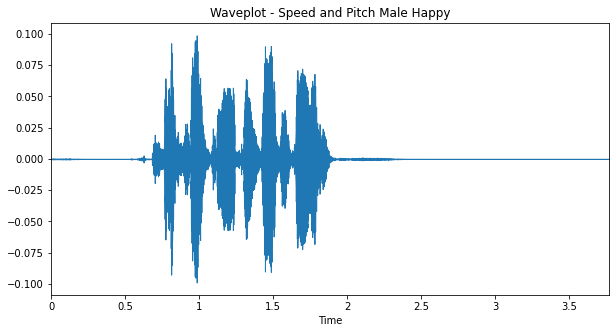

In [27]:
# ADD SPEED AND PITCH TO MALE Happy ORIGINAL AUDIO FILE
x = speedNpitch(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Happy')

The above shown all distints waveplots have been created after adding Noise, Stretch, Speed and Pitch to Original Audio File.

Apply Data Augmentation Methods to Train Set

In [28]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-68.16176, -68.16176, -68.16176, -68.05568, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-66.06582, -66.0507, -66.06643, -66.07191, -6..."
3,"[-63.501076, -63.501076, -63.420914, -62.75046..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [29]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-68.16176, -68.16176, -68.16176, -68.05568, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-66.06582, -66.0507, -66.06643, -66.07191, -6..."
3,"[-63.501076, -63.501076, -63.420914, -62.75046..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [30]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-69.44205, -69.44205, -69.3479, -69.36235, -6..."
1,"[-68.91249, -68.90266, -69.055695, -68.8534, -..."
2,"[-67.37247, -67.3832, -67.40518, -67.311295, -..."
3,"[-64.46494, -64.4077, -61.573734, -55.840633, ..."
4,"[-70.65653, -70.571266, -70.43312, -70.38798, ..."


In [31]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-68.16176, -68.16176, -68.16176, -68.05568, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-66.06582, -66.0507, -66.06643, -66.07191, -6..."
3,"[-63.501076, -63.501076, -63.420914, -62.75046..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


# Combine Tables For Modeling

In [32]:
# EXTRACT EMOTION LABELS FROM TRAIN
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [33]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [34]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [35]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

In [36]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [37]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813969,-38.328606,-39.064583,-40.051395,-40.789944,angry
4604,-75.133110,-75.315697,-75.560944,-75.835281,-76.157875,-76.135368,-74.641289,-71.589348,-72.556984,-75.086311,...,-75.591003,-74.922226,-74.993004,-75.281715,-75.898544,-75.818367,-75.410301,-75.072365,-75.467789,sad
4605,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,...,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,sad
4606,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm
4607,-49.329632,-49.102230,-49.301510,-49.695385,-49.817989,-49.963058,-50.396370,-50.743469,-50.763409,-51.183369,...,-48.659504,-48.363129,-47.912518,-46.909565,-47.177670,-48.008980,-49.500362,-50.187866,-51.033173,fear


The new Dataframe after implementing data augmentation technique and extracting distinct features by using Mel spectrogram.

In [38]:
mfcc.shape,noise.shape,speedpitch.shape,stretch.shape

((1152, 260), (1152, 260), (1152, 260), (1152, 260))

In [39]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

# Feature Extraction for Test Set